# Task and Setup

Data used - Quora Data containing question pairs and labels whether the pair is a duplicate or not.

The data can be found in Moodle in a csv file. This data is subject to Quora's [Terms of Service](https://www.quora.com/about/tos), allowing for non-commercial use. The dataset was downloaded from https://www.kaggle.com/quora/question-pairs-dataset. 


In [3]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt


# For pre-prcoessing


import zipfile
import urllib.request

from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
import string

# For tensorboard
import time
from torch.utils.tensorboard import SummaryWriter

# For model

import torch.nn as nn
import torch.nn.functional as F

In [4]:
# using device available - did not have GPU, using device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device in use:", device)

Device in use: cpu


### Data-Exploration

In [5]:
df = pd.read_csv("mini_quora_dataset_30_50_50k.csv")

In [6]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,max_length
0,307549,603786,603787,What are some different ways to make money fast?,What are fast ways to make money?,1,48
1,221916,437426,437427,How can I continue to improve my English?,How can I understand english?,1,41
2,177830,351280,351281,How do I promote my youtube videos?,What is the best way to promote YouTube videos?,1,47
3,128018,253605,253606,How can I organize a Quora Meetup in Pune?,Is there a Pune Quora Meetup group?,0,42
4,177761,351144,351145,What is the most badass moment of Game of Thro...,Who will die in season 5 of Game of Thrones?,0,50


In [7]:
### Exploring the dataset

In [8]:
df.max_length.max()

50

In [9]:
df['question1'].str.split().str.len().max()

15

In [10]:
df['question1'].str.split().str.len().max()

15

In [11]:
df[df.is_duplicate == 1].is_duplicate.count()

24102

In [12]:
df[df.is_duplicate == 0].is_duplicate.count()

25898

In [13]:
df.question1.sample(10)

22758            What are some good movies on planning?
20893              Why don't we celebrate Columbus Day?
20199           Why is Spotify nott available in India?
36747              How is it like to have a huge penis?
34330                    When do we use "to" and "for"?
2117       What would life on another planet look like?
2925           How can I find my path and my dream job?
45791      What would happen if earth stopped rotating?
20713    Do eubacteria have cell walls? Why or why not?
28268          Which one Should I buy -a Car or a bike?
Name: question1, dtype: object

### Download Embedding

In [14]:
# # Download zip file
# url = 'https://huggingface.co/stanfordnlp/glove/resolve/main/glove.twitter.27B.zip'
# # or https://nlp.stanford.edu/data/glove.twitter.27B.zip
# filename = 'GloVe.zip'
# urllib.request.urlretrieve(url, filename)

# ## unzip data
# with zipfile.ZipFile( "GloVe.zip", 'r') as zip_ref:
#     zip_ref.extractall("GloVe")

### 1.a Load Embeddings 

In [15]:
### Background for extracting vocab and corresponding embeddings

vocab,embeddings = [],[]
PAD_TOK, UNK_TOK = '<pad>','<unk>'

# Download Glove embedding 50Dimention

with open('GloVe/glove.twitter.27B.50d.txt','rt', encoding='UTF-8',) as fi:
    full_content = fi.read().strip().split('\n')
    
for i in range(len(full_content)):
    i_word = full_content[i].split(' ')[0]
    i_embeddings = [float(val) for val in full_content[i].split(' ')[1:]]
    vocab.append(i_word)
    embeddings.append(i_embeddings)

# converting to np array

vocab_npa = np.array(vocab)
embs_npa = np.array(embeddings)

# insert '<pad>' for padding and '<unk>'  for unknown, tokens at start of vocab_npa.
vocab_npa = np.insert(vocab_npa, 0, PAD_TOK)
vocab_npa = np.insert(vocab_npa, 1, UNK_TOK)
print(vocab_npa[:10])

#embedding for '<pad>' token = zeros
pad_emb_npa = np.zeros((1, embs_npa.shape[1]))   

#embedding for '<unk>' token = mean
unk_emb_npa = np.mean(embs_npa, axis=0, keepdims=True)    

#insert embeddings for pad and unk tokens at top of embs_npa.
embs_npa = np.vstack((pad_emb_npa, unk_emb_npa, embs_npa))
print(embs_npa.shape)

['<pad>' '<unk>' '<user>' '.' ':' 'rt' ',' '<repeat>' '<hashtag>'
 '<number>']
(1193519, 50)


In [16]:
len(embeddings)

1193517

In [17]:
embs_npa.shape, vocab_npa.shape

((1193519, 50), (1193519,))

### 1.b Create Dataset

In [18]:
class Question_dataset(torch.utils.data.Dataset):
    
    def __init__(self, df, vocab, pad_token, unk_token, max_seq_length = 8):
        
        # Create vocab with dict
        self.word2idx = {term:idx for idx,term in enumerate(vocab)}
        self.idx2word = {idx:word for word,idx in self.word2idx.items()}
        self.pad_token = pad_token
        self.unk_token = unk_token
        self.df = df
        
        # Initialize needed features and labels
        self.pad_token, self.unk_token = pad_token, unk_token
        self.q1_input_ids = []
        self.q2_input_ids = []
        self.q1_sequence_len = []
        self.q2_sequence_len = []
        self.labels = []
        
        # Pre-processing the data
        self.pre_processing()
        
        # Get input ids for the corresponding text features
        for i in range(df.shape[0]):
            q1_input_ids, q2_input_ids, q1_sequence_len, q2_sequence_len = self.convert_text_to_input_ids(df.iloc[i].q1, df.iloc[i].q2, pad_to_len=max_seq_length)
            
            self.q1_input_ids.append(q1_input_ids.reshape(-1))
            self.q2_input_ids.append(q2_input_ids.reshape(-1))
            self.q1_sequence_len.append(q1_sequence_len)
            self.q2_sequence_len.append(q2_sequence_len)
            self.labels.append(df.iloc[i].is_duplicate)
        
        # Check if the text have the correct shape as per the df
        assert len(self.q1_input_ids) == df.shape[0]
        assert len(self.q2_input_ids) == df.shape[0]
        assert len(self.q1_sequence_len) == df.shape[0]
        assert len(self.q2_sequence_len) == df.shape[0]
        assert len(self.labels) == df.shape[0]
    
    def pre_processing(self):
        
        self.df.drop(['id','qid1','qid2'], axis = 1, inplace = True)
        self.df.fillna(" ", inplace = True)
        
        # remove chinese characters questions
        
        stop_words = set(stopwords.words('english', 'lang')) 
        keep_words = ['what','where','how','when','who','whom','until','won','there','why','will','during','further',
                     'should','if','then','they','those','which','did', 'for', 'by', 'from', 'is']
        for i in keep_words:
            stop_words.remove(i)

        lemmatizer = WordNetLemmatizer()

        tokenizer = RegexpTokenizer(r'\w+')
        q1 = []
        q2 = []

        for (col_name,col_val) in df.iteritems():
            if col_name == "question1":
                for i in range(len(col_val)):
                    word_tokens = tokenizer.tokenize(col_val[i].lower())
                    filtered_sentence = []
                    filtered_sentence = [lemmatizer.lemmatize(w) for w in word_tokens if not w in stop_words] 
                    q1.append(' '.join(filtered_sentence))

            if col_name == "question2":
                for i in range(len(col_val)):
                    word_tokens = tokenizer.tokenize(col_val[i].lower())
                    filtered_sentence = []
                    filtered_sentence = [lemmatizer.lemmatize(w) for w in word_tokens if not w in stop_words] 
                    q2.append(' '.join(filtered_sentence))

        self.df["q1"] = q1 
        self.df["q2"] = q2
        
    def convert_text_to_input_ids(self, q1, q2, pad_to_len):
        
        # Getting words and padding length and adding padding
        q1_words = q1.strip().split()[:pad_to_len]
        q1_deficit = pad_to_len - len(q1_words)
        q1_words.extend([self.pad_token]*q1_deficit)
        
        q2_words = q1.strip().split()[:pad_to_len]
        q2_deficit = pad_to_len - len(q2_words)
        q2_words.extend([self.pad_token]*q2_deficit)
    
        for i in range(len(q1_words)):
            if q1_words[i] not in self.word2idx:
                q1_words[i] = self.word2idx[self.unk_token]
            else:
                q1_words[i] = self.word2idx[q1_words[i]]
                
        for i in range(len(q2_words)):
            if q2_words[i] not in self.word2idx:
                q2_words[i] = self.word2idx[self.unk_token]
            else:
                q2_words[i] = self.word2idx[q2_words[i]]
                
        return torch.Tensor(q1_words).long(), torch.Tensor(q2_words).long(), pad_to_len - q1_deficit, pad_to_len - q2_deficit

    def get_text(self, df):
        self.q1 = df["question1"]
        self.q2 = df["question2"]
    
    def __len__(self):
        return len(self.q1_input_ids)
    
    def __getitem__(self, sample_id):
        sample_dict = dict()
        sample_dict['q1'] = self.q1_input_ids[sample_id].reshape(-1)
        sample_dict['q1_sequence_len'] = torch.tensor(self.q1_sequence_len[sample_id]).long()
        sample_dict["q1_text"] = self.df.iloc[sample_id].question1
        
        
        sample_dict['q2'] = self.q2_input_ids[sample_id].reshape(-1)
        sample_dict['q2_sequence_len'] = torch.tensor(self.q2_sequence_len[sample_id]).long()
        sample_dict["q2_text"] = self.df.iloc[sample_id].question2
        
        sample_dict['labels'] = torch.tensor(self.labels[sample_id])
        
        return sample_dict

In [19]:
complete_dataset = Question_dataset(df, vocab, PAD_TOK, UNK_TOK)

In [29]:
# Splitting the dataset in train, val and test as 70,20,10

train_len,val_len, test_len = int(0.7*len(complete_dataset)) , int(0.2*len(complete_dataset)), int(0.1*len(complete_dataset))
train_dataset,val_dataset,test_dataset = torch.utils.data.random_split(complete_dataset,[train_len,val_len,test_len],generator=torch.Generator().manual_seed(32))

In [30]:
len(train_dataset), len(val_dataset), len(test_dataset)

(35000, 10000, 5000)

In [31]:
hparams = {
    
    'epochs' : 10,
    'learning_rate' : 0.0035, 
    'batch_size' : 128, 
    'lstm_layers' : 2,
    'hidden_dim' : 50,
   
}

### 1.c Create Dataloaders for Train, Val and Test dataset

In [32]:
train_data = torch.utils.data.DataLoader(train_dataset, hparams["batch_size"], shuffle = True)
val_data = torch.utils.data.DataLoader(val_dataset, hparams["batch_size"], shuffle = True)
test_data = torch.utils.data.DataLoader(test_dataset, hparams["batch_size"], shuffle = True)

In [58]:
### Your code goes here ####

class Classification_model(nn.Module):
    
    def __init__(self, pre_embedding, batch_size, lstm_layers, hidden_dim):
        
        super(Classification_model, self).__init__()
        
        self.vocab_size = pre_embedding.shape[0]
        # output as emb_dimention and Freezing the embedding so that it does not get trained
        
        self.batch_size = batch_size
        self.hidden_dim = hidden_dim
        self.LSTM_layers = lstm_layers
        self.input_size = pre_embedding.shape[1] # embedding dimention

        self.dropout = nn.Dropout(0.5)
        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(pre_embedding).float(),freeze=True)
        self.lstm = nn.LSTM(input_size=self.hidden_dim, hidden_size=self.hidden_dim, num_layers=self.LSTM_layers, batch_first=True)
        self.fc1 = nn.Linear(in_features=self.hidden_dim*2, out_features=192)
        self.fc2 = nn.Linear(in_features = 192, out_features = 2)

    def forward(self, x):
        
        # LSTM initialization for Q1
        q1 = x['q1']
        q1_slen = x['q1_sequence_len']
       
        h_q1 = torch.zeros((self.LSTM_layers, q1.size(0), self.hidden_dim))
        c_q1 = torch.zeros((self.LSTM_layers, q1.size(0), self.hidden_dim))       
        torch.nn.init.xavier_normal_(h_q1)
        torch.nn.init.xavier_normal_(c_q1)
        
        # Embedding for Q1
        out_q1 = self.embedding(q1)
        
        # LSTM layer for Q1
        out_q1, (hidden, cell) = self.lstm(out_q1, (h_q1,c_q1))
        out_q1 = self.dropout(out_q1)
       
        ##############################################
        
        # LSTM initialization for Q2
        q2 = x['q2']
        q2_slen = ['q2_sequence_len']     
        
        
        h_q2 = torch.zeros((self.LSTM_layers, q2.size(0), self.hidden_dim))
        c_q2 = torch.zeros((self.LSTM_layers, q2.size(0), self.hidden_dim))       
        torch.nn.init.xavier_normal_(h_q2)
        torch.nn.init.xavier_normal_(c_q2)

        # Embedding for Q2
        out_q2 = self.embedding(q2)
                
        # LSTM layer for Q2
        out_q2, (hidden, cell) = self.lstm(out_q2, (h_q2,c_q2))
        out_q2 = self.dropout(out_q2)
        
        ####################################################
        
        # Combining the two lstm layer output for linear layer using concat in dimention 2
        out = torch.cat((out_q1, out_q1), 2 )  
        out = self.fc1(out[:,-1,:])
        out = torch.relu_(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = torch.sigmoid(out)
        
        return out


In [59]:
model = Classification_model(embs_npa, hparams["batch_size"], hparams["lstm_layers"], hparams["hidden_dim"] )

In [60]:
hparams

{'epochs': 10,
 'learning_rate': 0.0035,
 'batch_size': 128,
 'lstm_layers': 2,
 'hidden_dim': 50}

In [61]:
# Checking the shape of the dataloader batch

model_test = Classification_model(embs_npa, hparams["batch_size"], hparams["lstm_layers"], hparams["hidden_dim"] )

for i, batch in enumerate(train_data):
    
    #input to the model is dictionary
    print("input:", batch["q1"].size(), batch["q2"].size())
    
    #output from the model shape
    y_pred = model_test(batch)
    print("output:", y_pred.shape)
    break
    

input: torch.Size([128, 8]) torch.Size([128, 8])
torch.Size([128, 8, 50]) torch.float32 torch.float32
output: torch.Size([128, 2])


In [38]:
class Model_trainer:

    def __init__(self, hparams, model, train_data, val_data):
        
        self.hparams = hparams
        self.batch_size = hparams["batch_size"]
        self.train_data = train_data
        self.val_data = val_data
        
        # pass all the training arguments
        self.model = model
        
        # Logging the history and displaying graph later
        self.train_loss_history = [] 
        self.train_acc_history = [] 
        self.val_acc_history = []
        self.val_loss_history = []
        
        # Create Tensorboard - writer
        self.writer = self.initialize_tensorboard()
        
        

    def train(self):

        optimizer = torch.optim.Adam(self.model.parameters(), lr=hparams["learning_rate"])
        criterion = nn.CrossEntropyLoss()
        
        for epoch in range(self.hparams["epochs"]):

            train_predictions = []
            train_labels = []
            running_loss = 0.0
            correct = 0.0
            total = 0
            
            
            self.model.train()

            for i, batch in enumerate(self.train_data):
              
                optimizer.zero_grad()
                y = batch["labels"]
                y_pred = self.model(batch)
                
                loss = criterion(y_pred, y)
                
                loss.backward()
                optimizer.step()
                                
                # Accumulate the loss and calculate the accuracy of predictions
                running_loss += loss.item()
                
                #convert output probabilities of each class to a singular class prediction
                _, preds = torch.max(y_pred, 1) 
            
                correct += preds.eq(y).sum().item()
                total += y.size(0)
                
                # Print the statistics every 200 mini-batch
                if  i % 200 == 199:    
                    running_loss /= 200
                    correct /= total
                    print("[Epoch %d, Iteration %5d] training loss: %.3f training acc: %.2f %%" % (epoch+1, i+1, running_loss, 100*correct))
                    self.train_loss_history.append(running_loss)
                    self.train_acc_history.append(correct)
                    train_acc = correct
                    
                    # log the running loss on tensorboard for Traininig data
                    self.writer.add_scalar('Training loss',running_loss / 200,epoch * len(self.train_data) + i)
                    self.writer.add_scalar('Training Accuracy', correct*100, epoch * len(self.train_data) + i)

                    running_loss = 0.0
                    correct = 0.0
                    total = 0
                        
            # calculating validation accuracy after every epoch on the complete val dataset
            val_loss, val_accuracy = self.evaluation(criterion)            
            self.val_acc_history.append(val_accuracy)
            self.val_loss_history.append(val_loss)
            print("------------[Epoch: %d] Val Loss: %.5f Val accuracy: %.2f %%------------" % (epoch+1, val_loss, val_accuracy*100))

            # log the accuracy on tensorboard for Validation data
            self.writer.add_scalar('Validation Accuracy', val_accuracy*100, epoch * len(self.val_data) + i)
            self.writer.add_scalar('Validation Loss', val_loss, epoch * len(self.val_data) + i)

        
        self.writer.add_hparams(self.hparams, {'Vald Accuracy': self.val_acc_history[-1]*100, 'Train Accuracy': self.train_acc_history[-1]*100 })
        self.writer.close()
        
    def evaluation(self, criterion):
        
        ## evaluating on the validation data 
        running_loss = 0.0
        correct = 0
        total = 0
        
        self.model.eval()
        with torch.no_grad():
            for i , batch in enumerate(self.val_data):
               
                y = batch["labels"]
                y_pred = self.model(batch)
                
                loss = criterion(y_pred, y)
                running_loss += loss.item()

                _, val_preds = torch.max(y_pred, 1) 
                correct += val_preds.eq(y).sum().item()
                total += y.size(0)
        
            val_accuracy = correct/total
            val_loss = running_loss/total

            return val_loss, val_accuracy
    
    def visualize_train(self):
        
        """ Visualizing the training data """
        plt.plot(self.train_acc_history)
        plt.plot(self.train_loss_history)
        plt.title("Questions Dataset")
        plt.xlabel('iteration')
        plt.ylabel('train acc/ train loss')
        plt.legend(['Train Acc', 'Train Loss'])
        plt.show()
        
    def visualize_val(self):
        
        """ Visualizing the training data """
        plt.plot(self.val_acc_history)
        plt.plot(self.val_loss_history)
        plt.title("Questions Dataset")
        plt.xlabel('iteration')
        plt.ylabel('Val Acc / Val Loss')
        plt.legend(['Val Acc', 'Val Loss'])
        plt.show()
        
    def visualize_train_val(self):
        
        """ Visualizing the training and validation data """
        plt.plot(self.train_loss_history)
        plt.plot(self.val_loss_history)
        plt.title("Questions Dataset")
        plt.xlabel('iteration')
        plt.ylabel('Train Loss / Val Loss')
        plt.legend(['Train Loss', 'Val Loss'])
        plt.show()
        
        
    def initialize_tensorboard(self):
        
        current_time = time.strftime("%d%m_%Hh_%Mm")
        writer = SummaryWriter('runs/QuestionsDataset/'+current_time)
        
        return writer

In [39]:
Train = Model_trainer(hparams, model, train_data, val_data)
Train.train()

torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])


torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([16, 8, 50])
------------[Epoch: 1] Val Loss: 0.00519 Val accuracy: 60.09 %------------
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
t

torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])


torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([56, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
t

torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])


torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])


torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
[Epoch 6, Iteration   200] training loss: 0.583 training acc: 70.66 %
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch

torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])


torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])


torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])


torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])


In [40]:
### Visualization available on tensorboard at 'runs/QuestionsDataset' with the timestamp of execution for versioning

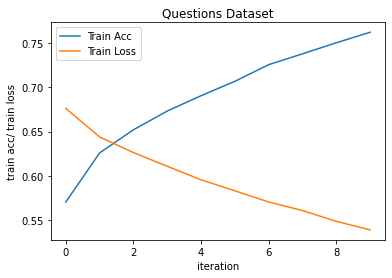

In [41]:
Train.visualize_train()

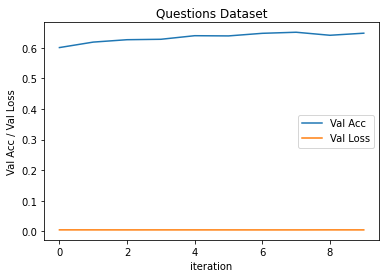

In [42]:
Train.visualize_val()

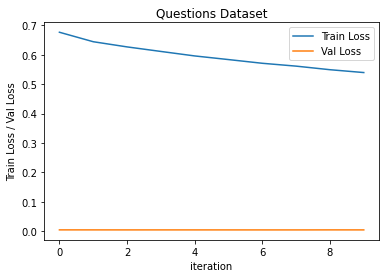

In [43]:
Train.visualize_train_val()

In [44]:
# Saving the model dictionary
torch.save(model.state_dict(), "./model.pt")

### Testing

In [46]:
class test_trainer:

    def __init__(self, model, test_data):

        self.test_data = test_data
        self.model = model

    def evaluate(self):
              
        test_accuracy = self.test_evaluation()
        print("Test accuracy: %.5f" % (test_accuracy*100))
            
    def test_evaluation(self):

        ## evaluating on the validation data 
        correct = 0
        total = 0
        
        self.model.eval()
        with torch.no_grad():
            
            for i, batch in enumerate(self.test_data):
                y = batch["labels"]
                y_pred = self.model(batch)

                _, test_pred = torch.max(y_pred, 1) 
                correct += test_pred.eq(y).sum().item()
                total += y.size(0)
            
            test_accuracy = correct/total

            return test_accuracy

### Evaluation

In [47]:
# Evaluation on the test dataset
test = test_trainer(model, test_data)
test.evaluate()

torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([128, 8, 50])
torch.Size([8, 8, 50])
Te

In [48]:
### Evaluate on random samples from different dataset

import random

def Check_on_random_samples(n, dataset, model):

    randomlist = random.sample(range(1, len(dataset)), n)
    subset = torch.utils.data.Subset(dataset, randomlist)
    testloader_subset = torch.utils.data.DataLoader(subset, batch_size=1, num_workers=0, shuffle=False)


    for i in (testloader_subset):
        model.eval()
        prediction = model(i)
        _, prediction = torch.max(prediction, 1)
        print("Q1:", (i["q1_text"]))
        print("Q2:", (i["q2_text"]))
        print("Prediction:", int(prediction))
        print("Label:", int(i["labels"]))
        # True indicating the correct prediction in this case
        print("--- Predicted Result is",prediction.eq(i["labels"]).item() )
    

In [49]:
# enter the number of samples to test randomply from the different datasets
# train_dataset
# val_dataset
# test_dataset

# n = int(input("Enter number of samples to check "))
n = 3
print("\n--------------------On training Dataset--------------------")
Check_on_random_samples(n ,train_dataset, model)
print("\n--------------------On Validation Dataset--------------------")
Check_on_random_samples(n ,val_dataset, model)
print("\n--------------------On Test Dataset--------------------")
Check_on_random_samples(n ,test_dataset, model)



--------------------On training Dataset--------------------
torch.Size([1, 8, 50])
Q1: ['How much money do uber drivers make in Cincinnati?']
Q2: ['How much money do Uber drivers make in Sacramento?']
Prediction: 0
Label: 0
--- Predicted Result is True
torch.Size([1, 8, 50])
Q1: ['What is there to do in Barcelona?']
Q2: ['What can I do in Barcelona?']
Prediction: 1
Label: 1
--- Predicted Result is True
torch.Size([1, 8, 50])
Q1: ['What are some ways to lose 80 pounds in 4 months?']
Q2: ['How do I lose 50 pounds in 2 months?']
Prediction: 0
Label: 0
--- Predicted Result is True

--------------------On Validation Dataset--------------------
torch.Size([1, 8, 50])
Q1: ['What are the different types of proteins in food?']
Q2: ['What are the different types of protein?']
Prediction: 0
Label: 0
--- Predicted Result is True
torch.Size([1, 8, 50])
Q1: ['How can I convince my parents?']
Q2: ['How will convince my parents?']
Prediction: 0
Label: 1
--- Predicted Result is False
torch.Size([1, 8,

<div class="alert alert-info">

### Design Choice:

- GloVe Twitter Embedding with `50 dimentions` were used
- Preprocssing steps used - Lammetization and stop_word removal - customized the choosen stop_words.
- Model Design: Two parallel `LSTM layers` were used for each question and further two `fully connected Linear layers` were used after concatinating the two LSTM layer tensors, finally a sigmoid layer was put forth for the classification
- Loss : `Cross Entrophy Loss` - classical data classification loss
- Optimizer: `Adam`
- Created Custome Trainer class for training, validation and test dataset
- Added `Tensorboard` for monitoring Training Loss, Training, Validation Accuracy and Hyper-params
- For Evaluation - `n` random samples can be picked and checked for Duplication

### Obeservation:

- Model performs `77 percent`(approx) accuracy on the Training Dataset (35k observation) and around `65 percent`(approx) on the Validation dataset (10k)
- Model performs close to `65 percent`(approx) on the Test Dataset(5k)
- Further Hyper-parameter tuning, more preprocessing steps and using higher dimention embedding might increase the accuracy of the model.
- In terms of Architecture, Bidirectional LSTM or Siamese Architecture could have been used.
    
### Learnings
- I personally learned how to create a deep learning model from the absolute scratch, it was a nice mini-project to work up on. There is a lot of room for further learning. 

### Reference:
My work is inspired and referenced from : https://towardsdatascience.com/text-classification-with-pytorch-7111dae111a6 and <br>
https://github.com/tanmay17061/pytorch-potpourri/blob/master/tutorial_scripts/unilstm.ipynb    
    
</div>